In [1]:
# import required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import gzip

from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

In [2]:
# url text dataset from amazon about software review
dataset_url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz'

In [3]:
# download dataset file from url
# fname represent filename of downloaded file
# extract false keep the downloaded file un-extracted
dataset_dir = utils.get_file(fname='amazon_reviews_us_Software_v1_00.tsv.gz', origin=dataset_url, cache_subdir='amazon', extract=False, cache_dir='/content/')

In [5]:
# open donwloaded dataset file in directory with mode read as text (rt)
file = gzip.open(dataset_dir, mode='rt')

# read opened file as csv with delimiter tab (\t)
# ignore row with null column, some of row have null column
# set low of memory to false to avoid out of memory when read large file 
csv_ds = pd.read_csv(file, sep='\t', error_bad_lines=False, skip_blank_lines=True, low_memory=False)

b'Skipping line 8021: expected 15 fields, saw 22\nSkipping line 34886: expected 15 fields, saw 22\nSkipping line 49286: expected 15 fields, saw 22\n'


In [6]:
# add new column with name 'label' in data frame
# purpose of this new column as label when slice dataset on step 'tf.data.Dataset.from_tensor_slices'
csv_ds['label'] = csv_ds.index

In [7]:
# casting datatype of column 'review_body' to string
# this step is required to avoid error when slice dataset on step 'tf.data.Dataset.from_tensor_slices'
csv_ds['review_body'] = csv_ds['review_body'].astype(str)

In [8]:
# check dataset value
csv_ds.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,label
0,US,42605767,R3EFW2STIYIY0I,B00MUTIDKI,248732228,McAfee 2015 Internet Security 3 PC (3-Users),Software,1,2,2,N,Y,I was very disappointed with this,I was very disappointed with this. The descrip...,2015-08-31,0
1,US,51771800,R12NR0R5A9F7FT,B00EPACNUG,531462352,Hallmark Card Studio 2014,Software,5,0,0,N,Y,Five Stars,"I had a little struggle getting familiarized, ...",2015-08-31,1
2,US,16053526,R1LSH74R9XAP59,B00164AZA4,473982505,Search and Rescue 4,Software,2,0,1,N,Y,Have windows 10?,Tried to download it on my Windows 10 and it w...,2015-08-31,2
3,US,15319481,R1QXUNTF76K7L6,B00E6LIEFM,189774198,Quickbooks Pro,Software,2,0,0,N,Y,"Disc was corrupt, had to spend a couple hours ...","Disc was corrupt, had to spend a couple hours ...",2015-08-31,3
4,US,1441820,R2F7DR75PS8NKT,B00VWEBG06,852470365,Windows 7 Professional with Service Pack 1 (64...,Software,5,0,0,N,Y,Five Stars,Just what I needed. Took a little longer to sh...,2015-08-31,4


In [9]:
# check info of dataset
csv_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341249 entries, 0 to 341248
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        341249 non-null  object
 1   customer_id        341249 non-null  int64 
 2   review_id          341249 non-null  object
 3   product_id         341249 non-null  object
 4   product_parent     341249 non-null  int64 
 5   product_title      341249 non-null  object
 6   product_category   341249 non-null  object
 7   star_rating        341249 non-null  int64 
 8   helpful_votes      341249 non-null  int64 
 9   total_votes        341249 non-null  int64 
 10  vine               341249 non-null  object
 11  verified_purchase  341249 non-null  object
 12  review_headline    341246 non-null  object
 13  review_body        341249 non-null  object
 14  review_date        341241 non-null  object
 15  label              341249 non-null  int64 
dtypes: int64(6), object(

In [10]:
# split dataset for 80% training and 20 % testing with random 200 data
ds_train, ds_test = train_test_split(csv_ds, test_size=0.2, random_state=200)

In [11]:
# check total number of training data
len(ds_train)

272999

In [12]:
# check total number of testing data
len(ds_test)

68250

In [13]:
# check training dataset value
ds_train.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,label
295252,US,17763535,R1SCU6SNEIPAX1,B000JD3AIW,338138258,2006 TurboTax Deluxe Federal + State Deduction...,Software,1,11,36,N,N,bad software,Every time I try this 2006 TurboTax software I...,2006-12-29,295252
33083,US,43124610,R3K3GEQ3IAQQNI,B005CPP5SA,910544615,Yaesu VX-8DR Programming Software & USB Cable ...,Software,5,0,0,N,Y,Five Stars,Item arrived well packed and recipient was hap...,2015-02-19,33083
42921,US,7656667,RH6IAJO0H070O,B00009L1HO,789909980,Microsoft Money 2004 Premium,Software,5,0,0,N,Y,Five Stars,good,2015-01-09,42921
236994,US,14151126,R2R5UI17HN24WI,B002RS8EWY,330627998,TurboTax Basic Federal + efile 2009,Software,2,4,6,N,Y,"Been Using Turbo Tax For Years, But.....","I have been using Turbo Tax for many years, bu...",2010-02-05,236994
107986,US,36737938,R1ARDB8E6KIVLC,B000F4ASUI,511061219,DJ ToneXpress - The Ringtone Creator,Software,2,1,1,N,N,"Use to be the best, now the developer does not...",I have used this software for years and could ...,2014-01-08,107986


In [14]:
# check testing dataset value
ds_test.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,label
190345,US,40144589,RF4O8XUB8J2V3,B000JX5JGI,44405184,Jumpstart Kindergarten,Software,5,0,0,N,Y,Soccer-Karate-Poodle mom,My Preschooler and my kindergartner likes it a...,2012-02-15,190345
164124,US,41672402,R9FPDXPRD6RGF,B002PRIT0O,505580809,WriteItNow 4,Software,4,3,3,N,Y,A Seriously Good Tool for Any Writer,The WriteItNow 4 software is an awesome writin...,2013-01-10,164124
154866,US,21497984,RGNNIMJ7YQ0G6,B008RA5A00,534964191,Quicken Deluxe 2013,Software,2,0,0,N,N,PayPal (and eBay) Users BEWARE - There *is* a ...,So I run a business that is exclusively intern...,2013-02-22,154866
28335,US,20955278,R34UL1GS7MT8N8,B00FPSN9X2,254223658,"AVG INTERNET SECURITY 2014, 3 User 2 Year",Software,1,0,0,N,Y,This Item Never Worked with me and this is the...,This Item Never Worked with me and this is the...,2015-03-09,28335
258773,US,33867240,R1R7L7SQW5U667,B001B5J7LQ,359196058,Dragon NaturallySpeaking 10 Preferred - Medium...,Software,4,2,3,N,N,Better but not perfect,I've been looking for a plain speech to text c...,2009-02-09,258773


In [15]:
# remove column 'label' from training and testing dataset, store removed column to new variable for training and testing
label_train = ds_train.pop('label')
label_test = ds_test.pop('label')

In [16]:
# slice dataset to convert from type pandas dataframe to tensorflow dataframe
# if not converted to tensorflow dataset, dataset can't be used on step text vectorization
# column used for text classfication is review_body
tf_ds_train = (tf.data.Dataset.from_tensor_slices((
    ds_train['review_body'].values,
    label_train.values))
)

tf_ds_test = (tf.data.Dataset.from_tensor_slices((
    ds_test['review_body'].values,
    label_test.values))
)

In [17]:
# check training text and label
for example, label in tf_ds_train.take(1):
  print('text train: ', example.numpy())
  print('label train: ', label.numpy())

text train:  b"Every time I try this 2006 TurboTax software I get a new result for my tax return.   <br /> <br />I tried 5 times on this version using the same inputs + dozens other tests.  Other people told me that they had the same problem all the times.  <br /> <br />I don't know if the MAKER of this knows about this.  I gave this software 3 stars because I used TurboTax in 2004 & 2005 with the similar problem.  I filed them anyway ... But not this year ... because I don't want to pay more taxes and still get some money back on the same tax returns (according to this 2006 software)"
label train:  295252


In [18]:
# check testing text and label
for example, label in tf_ds_test.take(1):
  print('text test: ', example.numpy())
  print('label test: ', label.numpy())

text test:  b'My Preschooler and my kindergartner likes it a lot, no problem installing it on Windows vista and windows 2000. Great learning game.[[ASIN:B000JX5JGI Jumpstart Kindergarten]]'
label test:  190345


In [19]:
# shuffle and create batches of text and label for training and testing dataset

BUFFER_SIZE = 10000
BATCH_SIZE = 64

tf_ds_train = tf_ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_ds_test = tf_ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
# check training text and label after shuffle and create batches
for example, label in tf_ds_train.take(1):
  print('texts train: ', example.numpy()[:3])
  print()
  print('labels train: ', label.numpy()[:3])

texts train:  [b'Worked exactly as promised.  It is very user friendly.'
 b'While EW is very powerful when it comes to CSS, there are issues with the upgrade in my opinion.  If you upgrade from Frontpage and have used themes, I still haven\'t figured out how to change or remove the theme.  This includes being unable to edit a link list in the theme header.  In Frontpage, you fust went to the \\\\"tree\\\\" of the website and added, removed, or updated the information or pages.IF you like Frontpage then I see no good reason to upgrade.  FP is easier to use and great for the non-professional.  I sold my registered copy of FP when I bought EWQ and now wish I had not.  EW is for the semi-professional and professional webmaster.  It isnot user friendly to the newbie.  I have 4 webs and can use it, but miss the simplicity of FP 2003.'
 b"GIT really did a fine job with these comic collections. Too bad Marvel is now going totally online and won't let anyone have the actual comics in hand anymo

In [21]:
# check testing text and label after shuffle and create batches
for example, label in tf_ds_test.take(1):
  print('texts test: ', example.numpy()[:3])
  print()
  print('labels test: ', label.numpy()[:3])

texts test:  [b'My Preschooler and my kindergartner likes it a lot, no problem installing it on Windows vista and windows 2000. Great learning game.[[ASIN:B000JX5JGI Jumpstart Kindergarten]]'
 b"The WriteItNow 4 software is an awesome writing tool that lets you quickly conceptualize your story, and speed up the production time. It installs in minutes on a Win 7 PC, and so far I have no complaints. The software is as expected. There are separate tabs for writing sections: characters, chapters, events, and history tips. The characters in the story come alive with the visual image that displays connection between characters, like brother, sister, enemy, and friend. There's also the ability to add an image of the character to the file. The character tap have a feature that let you easily control, and organize your characters personality attributes. The software is very responsive, no wait time while clicking around between tabs."
 b'So I run a business that is exclusively internet based in

In [22]:
# create text vectorization with maximum vocabulary 10.000
VOCAB_SIZE = 10000
encoder = TextVectorization(max_tokens=VOCAB_SIZE)

# pass text vectorization encoder to training dataset
encoder.adapt(tf_ds_train.map(lambda text, label: text))

In [23]:
# get vocabulary object
vocab = np.array(encoder.get_vocabulary())

In [24]:
# display 50 vocabulary for checking
vocab[:50]

array(['', '[UNK]', 'the', 'to', 'i', 'and', 'a', 'it', 'of', 'is', 'for',
       'this', 'you', 'that', 'in', 'with', 'my', 'have', 'on', 'not',
       'br', 'was', 'but', 'as', 'are', 'software', 'be', 'so', 'if',
       'all', 'or', 'from', 'use', 'program', 'product', 'can', 'your',
       'had', 'me', 'an', 'they', 'will', 'do', 'its', 'at', 'very',
       'version', 'one', 'windows', 'just'], dtype='<U19')

In [25]:
encoded_example = encoder(example)[0:3].numpy()
encoded_example

array([[  16,    1,    5, ...,    0,    0,    0],
       [   2,    1,  238, ...,    0,    0,    0],
       [  27,    4,  172, ...,   26, 1062,   15]])

In [26]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'My Preschooler and my kindergartner likes it a lot, no problem installing it on Windows vista and windows 2000. Great learning game.[[ASIN:B000JX5JGI Jumpstart Kindergarten]]'
Round-trip:  my [UNK] and my [UNK] likes it a lot no problem installing it on windows vista and windows 2000 great learning [UNK] jumpstart kindergarten                                                                                                                                                                                                                                                                                                                                                                                                 

Original:  b"The WriteItNow 4 software is an awesome writing tool that lets you quickly conceptualize your story, and speed up the production time. It installs in minutes on a Win 7 PC, and so far I have no complaints. The software is as expected. There are separate tabs 

In [27]:
# create RNN model with layers LSTM 128 (first) and 64 (second) unit and return_sequences=True to continue the output as an input of second Bidirectional layer
model = tf.keras.Sequential([
    encoder,
    layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [28]:
# evaluate prediction of positive feedback
good_feeback = ('This application experience great, UI friendly, the animation were amazing and totally different with others.'
               'Thumbs up for the team.')
good_predictions = model.predict(np.array([good_feeback]))
print(good_predictions[0])

[0.00056379]


In [29]:
# evaluate prediction of positive feedback with padding before training
padding = "the " * 2000
good_predictions = model.predict(np.array([good_feeback, padding]))
print(good_predictions[0])

[0.00056379]


In [30]:
# evaluate prediction of negative feedback
bad_feeback = (
    'The Worst system ever!! Always crash, hang, force close, and even stole my personal identity.'
    'Hell no, give back my MONEY!!!')
bad_predictions = model.predict(np.array([bad_feeback]))
print(bad_predictions[0])

[-0.00116831]


In [31]:
# evaluate prediction of negative feedback with padding before training
padding = "the " * 2000
predictions = model.predict(np.array([bad_feeback, padding]))
print(bad_predictions[0])

[-0.00116831]


In [32]:
# compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [33]:
# training process
history = model.fit(tf_ds_train, epochs=10,
                    validation_data=tf_ds_test,
                    validation_steps=30)

Epoch 1/10
4266/4266 [==============================] - 852s 197ms/step - loss: -94931336.0000 - accuracy: 0.0000e+00 - val_loss: -238114624.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
4266/4266 [==============================] - 843s 198ms/step - loss: -474510432.0000 - accuracy: 0.0000e+00 - val_loss: -736375424.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
4266/4266 [==============================] - 858s 201ms/step - loss: -1096584192.0000 - accuracy: 0.0000e+00 - val_loss: -1460639872.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
4266/4266 [==============================] - 850s 199ms/step - loss: -1942891904.0000 - accuracy: 0.0000e+00 - val_loss: -2405326336.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
4266/4266 [==============================] - 876s 205ms/step - loss: -3010077184.0000 - accuracy: 0.0000e+00 - val_loss: -3567846400.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
4266/4266 [==============================] - 812s 190ms/step - loss: -4298236416.0000 - accuracy: 0.0000e+00 - val

In [34]:
# evaluate accuracy after training process
test_loss, test_acc = model.evaluate(tf_ds_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1067/1067 [==============================] - 97s 91ms/step - loss: -12755668992.0000 - accuracy: 1.4652e-05
Test Loss: -12755668992.0
Test Accuracy: 1.465201421524398e-05


(0.0, 530170058.8000001)

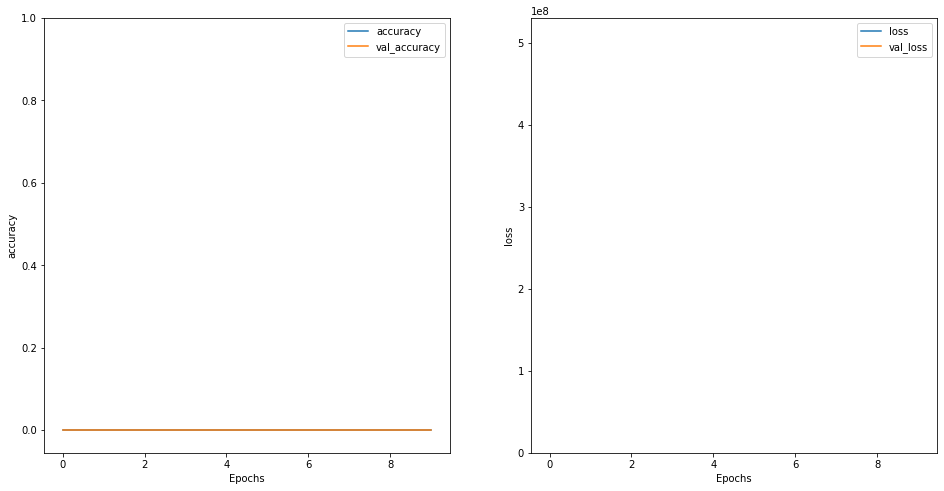

In [35]:
# chart accuracy
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [36]:
# evaluate prediction of positive feedback after training
positive_predictions = model.predict(np.array([good_feeback]))
print(positive_predictions[0])

[74942.38]


In [37]:
# evaluate prediction of negative feedback after training
negative_predictions = model.predict(np.array([bad_feeback]))
print(negative_predictions[0])

[74942.38]
